In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')
data_df.head()

,training_set,tot_ct,ex_ct,y,x
0,True,1588,66,-4.567814,ACGGUCCAU
1,True,1533,118,-3.688265,AUUGCCAGG
2,True,1459,399,-1.867896,ACAGCGGUA
3,True,1414,246,-2.518219,AACGCCAGG
4,True,1412,60,-4.533808,ACGGCUUGG


In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 24,411
testing N: 6,079


In [4]:
# Set filename
name = 'mpsa_ge_blackbox'

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='rna',
                     gpmap_type='blackbox',
                     gpmap_kwargs={
                         'hidden_layer_sizes':[10]*6,
                         'features':'pairwise'
                     },
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

# Fit model to data
model.fit(learning_rate=.002,
          epochs=1000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

# Save models
model.save(name)

N = 24,411 observations set as training data.
Data shuffled.
Time to set data: 0.38 sec.
Epoch 1/1000
196/196 [==============================] - 1s 6ms/step - loss: 127.5248 - I_like: -0.3806 - val_loss: 103.0387 - val_I_like: -0.0640
Epoch 2/1000
196/196 [==============================] - 1s 3ms/step - loss: 91.8246 - I_like: 0.0986 - val_loss: 83.7700 - val_I_like: 0.2117
Epoch 3/1000
196/196 [==============================] - 1s 3ms/step - loss: 80.5773 - I_like: 0.2602 - val_loss: 99.1052 - val_I_like: -0.0077
Epoch 4/1000
196/196 [==============================] - 1s 4ms/step - loss: 81.9456 - I_like: 0.2368 - val_loss: 78.6485 - val_I_like: 0.2835
Epoch 5/1000
196/196 [==============================] - 1s 4ms/step - loss: 79.0278 - I_like: 0.2814 - val_loss: 81.8743 - val_I_like: 0.2378
Epoch 6/1000
196/196 [==============================] - 1s 4ms/step - loss: 78.8431 - I_like: 0.2863 - val_loss: 78.6364 - val_I_like: 0.2864
Epoch 7/1000
196/196 [==============================] 

In [5]:
# Load model
model = mavenn.load(name)

Model loaded from these files:
	mpsa_ge_blackbox.pickle
	mpsa_ge_blackbox.h5


In [6]:
!du -k $name*

60	mpsa_ge_blackbox.h5
4	mpsa_ge_blackbox.pickle


In [7]:
# Get x and y
x = test_df['x']
y = test_df['y']

On test data:
I_like_test: 0.445 +- 0.024 bits
I_pred_test: 0.529 +- 0.019 bits


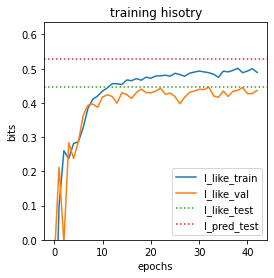

In [8]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x, y=y)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x, y=y)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_pred*1.2]);

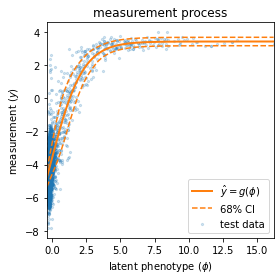

In [9]:
# Compute phi and yhat values
phi = model.x_to_phi(x)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [min(phi), max(phi)]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [10]:
# Test simulate_data
sim_df = model.simulate_dataset(N=1000)
sim_df.head()

,training_set,yhat,phi,y,x
0,True,-4.566136,-0.316426,-4.236444,UCAGCAAUA
1,False,-4.449330,-0.278914,-4.145420,GCUGUCUGA
2,True,-4.497510,-0.294376,-4.439435,CGAGCGUGU
3,True,-4.495832,-0.293838,-4.138467,GUCGCCUGU
4,True,-4.319793,-0.237406,-3.761661,UACGUGAAG
